In [1]:
import sys
sys.path.insert(1, '../functions')
from gk import gk
from mwrko import mwrko
from gko import gko
from method import method
from method2 import method2
from compute_sin2 import compute_sin2
import math 

In [2]:
# importing necessary libraries
from time import process_time
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import random
import math
from scipy import sparse
from scipy.sparse import random
from scipy import stats
from numpy.random import default_rng
from sklearn.preprocessing import normalize
import numpy as np
import pandas as pd
from itertools import permutations

# Convergence Rate

#### GK

$$||x_k - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{m} \right) ^k ||x_0 - x^*||^2$$ or
$$||x_k - x^*||^2 \leq \Pi^{k-1}_{j = 0} \left ( 1 - \frac{\sigma^2_\min (A)}{\gamma_{k+1}} \right) ||x_0 - x^*||^2$$ where $\gamma_{k+1} = \frac{||Ax_{k+1}-b||^2}{||Ax_{k+1}-b||^2_{\infty}}$. In this experiment, we are using first convergence rate for GK.

#### GKO and MWRKO

For k = 1: $$||x_1 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{m} \right) ||x_0 - x^*||^2$$

For k = 2: $$||x_2 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{ ( \max_i \sin^2\theta_i )(m-1)} \right)||x_1 - x^*||^2$$

For k > 2:

**GKO:** $$||x_{k+1} - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{\max_i \sin^2\theta_i} \right)||x_k - x^*||^2$$

**MWRKO:** $$||x_2 - x^*||^2 \leq \left ( 1 - \frac{\sigma^2_\min (A)}{ ( \max_i \sin^2\theta_i )(m-2)} \right) ||x_k - x^*||^2$$

## Gaussian System

In [3]:
# setting up data
A = np.random.randn(5000,500)
A = normalize(A, axis=1, norm='l2')
m,n = A.shape
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [4]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [5]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [6]:
# Run algorithms
gk_gaussian = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gaussian = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gaussian = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

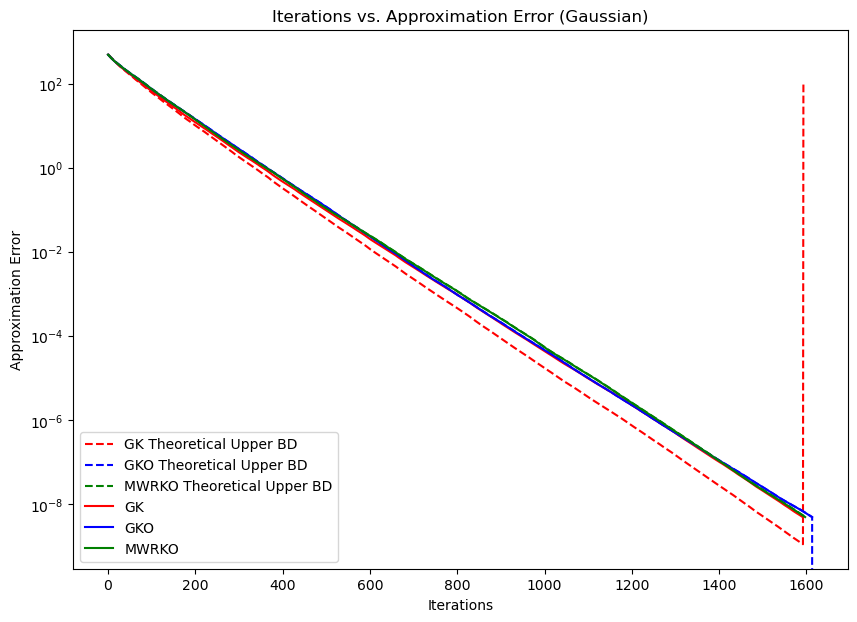

In [7]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gaussian[2])), gk_gaussian[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gaussian[2])), gko_gaussian[2], linestyle = 'dashed', 
            color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gaussian[2])), mwrko_gaussian[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gaussian[0] - 1), gk_gaussian[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gaussian[0] - 1), gko_gaussian[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gaussian[0] - 1), mwrko_gaussian[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian)')
plt.legend()

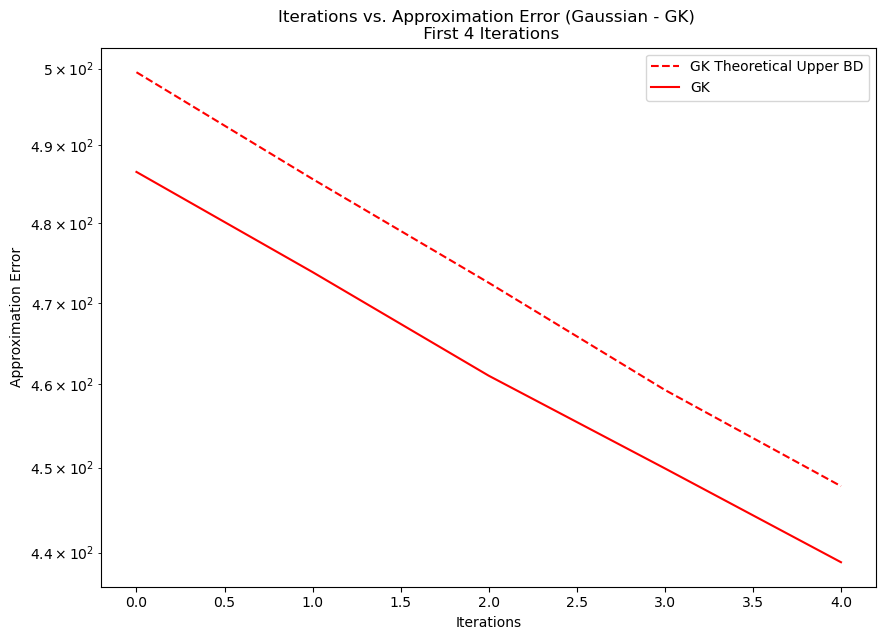

In [8]:
# Show GK empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gk_gaussian[2][0:5], linestyle = 'dashed', 
             color = "red", label = 'GK Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gk_gaussian[1][0:5], linestyle = 'solid', 
             color = "red", label = 'GK')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - GK) \n First 4 Iterations')
plt.legend()

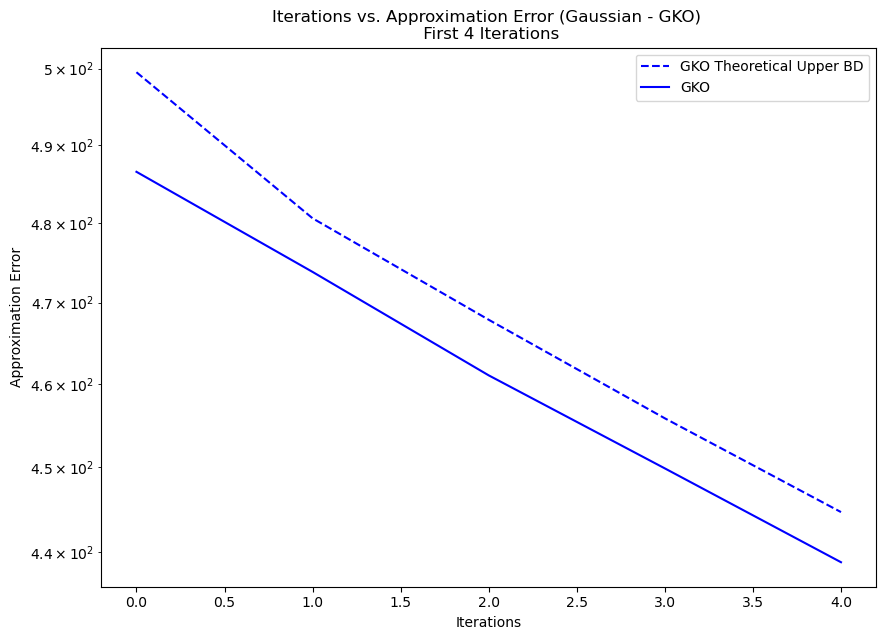

In [9]:
# Show GKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), gko_gaussian[2][0:5], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), gko_gaussian[1][0:5], linestyle = 'solid', 
             color = "blue", label = 'GKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - GKO) \n First 4 Iterations')
plt.legend()

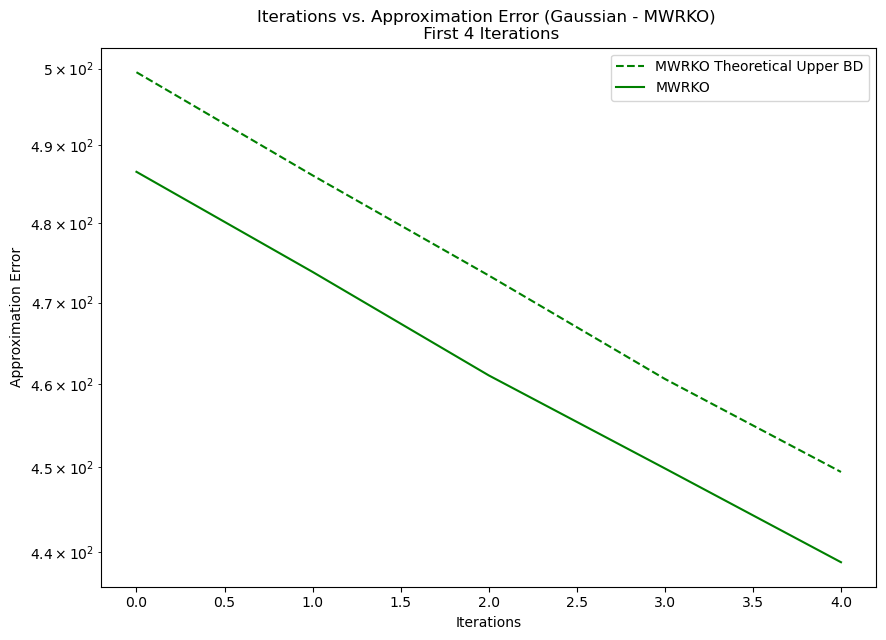

In [10]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gaussian[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gaussian[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Gaussian - MWRKO) \n First 4 Iterations')
plt.legend()

In [11]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gaussian[0]-9), mwrko_gaussian[0]+1)))
# empirical result data
e_result = list(mwrko_gaussian[1][0:10])
e_result.extend(list(mwrko_gaussian[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gaussian[2][0:10])
t_result.extend(list(mwrko_gaussian[2][-11:-1]))
# create and print df
mwrko_gauss_df = pd.DataFrame()
mwrko_gauss_df['k'] = k
mwrko_gauss_df['Theoretical BD'] = t_result
mwrko_gauss_df['Empirical Results'] = e_result
mwrko_gauss_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.590000e+03,1.591000e+03,1.592000e+03,1.593000e+03,1.594000e+03,1.595000e+03,1.596000e+03,1.597000e+03,1.598000e+03,1.599000e+03
Theoretical BD,499.530690,486.092255,473.393636,460.620949,449.427700,438.416251,426.613574,416.528373,406.394744,397.080328,5.906291e-09,5.808750e-09,5.718902e-09,5.628394e-09,5.539587e-09,5.448985e-09,5.373026e-09,5.291333e-09,5.212198e-09,5.129380e-09
Empirical Results,486.549031,473.838568,461.053877,449.850108,438.828309,427.014539,416.919859,406.776706,397.453535,387.734822,5.814209e-09,5.724277e-09,5.633684e-09,5.544793e-09,5.454106e-09,5.378076e-09,5.296306e-09,5.217096e-09,5.134201e-09,5.044728e-09


## Uniform System

In [12]:
# setting up data
A = np.random.uniform(size =(5000,500), low = 0, high = 1)
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [13]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [14]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [15]:
# Run algorithms
gk_uniform = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_uniform = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_uniform = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

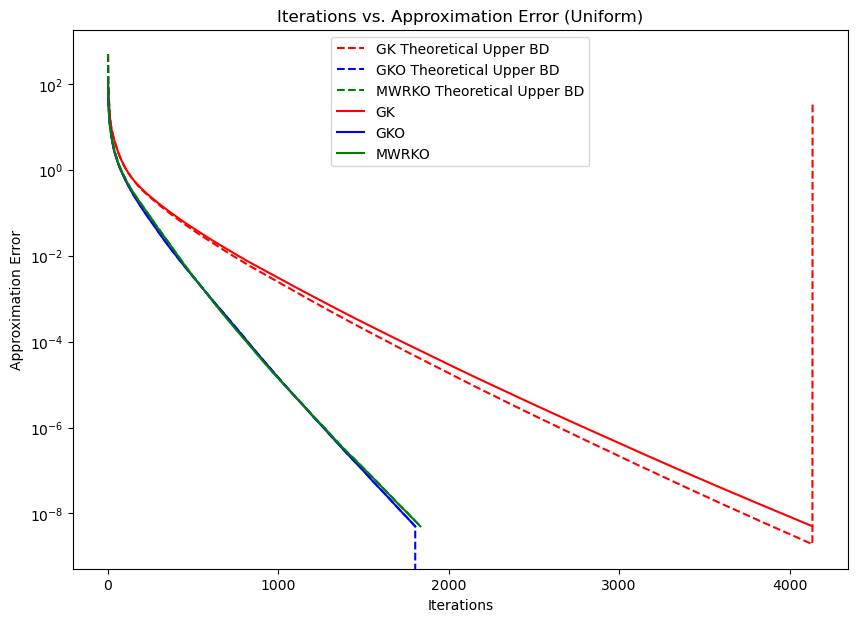

In [16]:
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_uniform[2])), gk_uniform[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_uniform[2])), gko_uniform[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_uniform[2])), mwrko_uniform[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_uniform[0] - 1), gk_uniform[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_uniform[0] - 1), gko_uniform[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_uniform[0] - 1), mwrko_uniform[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform)')
plt.legend()

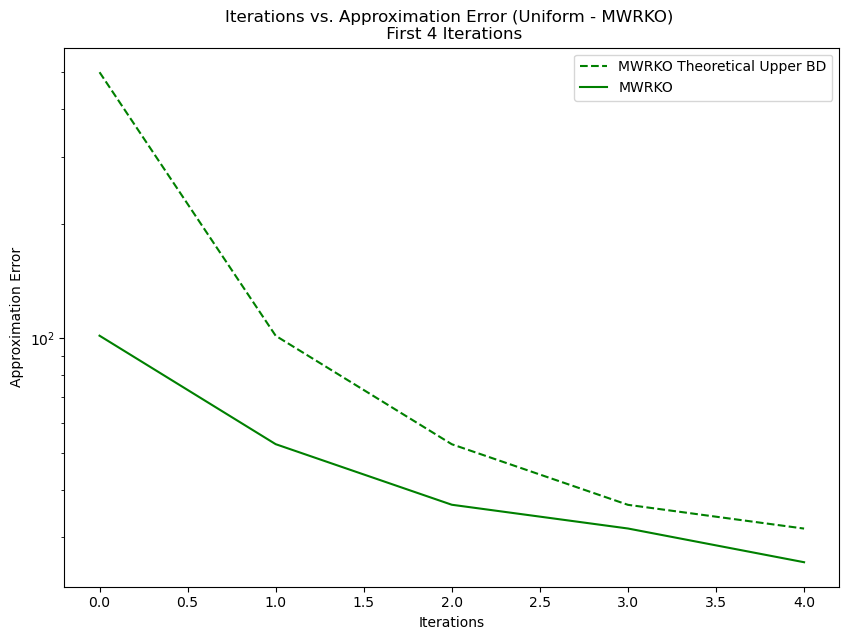

In [17]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_uniform[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_uniform[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Uniform - MWRKO) \n First 4 Iterations')
plt.legend()

In [18]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_uniform[0]-9), mwrko_uniform[0]+1)))
# empirical result data
e_result = list(mwrko_uniform[1][0:10])
e_result.extend(list(mwrko_uniform[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_uniform[2][0:10])
t_result.extend(list(mwrko_uniform[2][-11:-1]))
# create and print df
mwrko_uniform_df = pd.DataFrame()
mwrko_uniform_df['k'] = k
mwrko_uniform_df['Theoretical BD'] = t_result
mwrko_uniform_df['Empirical Results'] = e_result
mwrko_uniform_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.826000e+03,1.827000e+03,1.828000e+03,1.829000e+03,1.830000e+03,1.831000e+03,1.832000e+03,1.833000e+03,1.834000e+03,1.835000e+03
Theoretical BD,499.883066,101.469361,52.633588,36.480862,31.597950,25.766038,20.690315,19.122693,16.986358,14.989654,5.500435e-09,5.450023e-09,5.395303e-09,5.346821e-09,5.292490e-09,5.239503e-09,5.190642e-09,5.143676e-09,5.096770e-09,5.052458e-09
Empirical Results,101.512637,52.656041,36.496424,31.611430,25.777029,20.699141,19.130850,16.993604,14.996048,13.444912,5.452348e-09,5.397604e-09,5.349102e-09,5.294748e-09,5.241739e-09,5.192856e-09,5.145870e-09,5.098944e-09,5.054613e-09,5.007689e-09


## 50/50 Gauss-Uniform System

In [19]:
# setting up data
A1 = np.random.rand(2500,500)
A2 = np.random.randn(2500,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [20]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [21]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [22]:
# Run algorithms
gk_gu1 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu1 = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu1 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

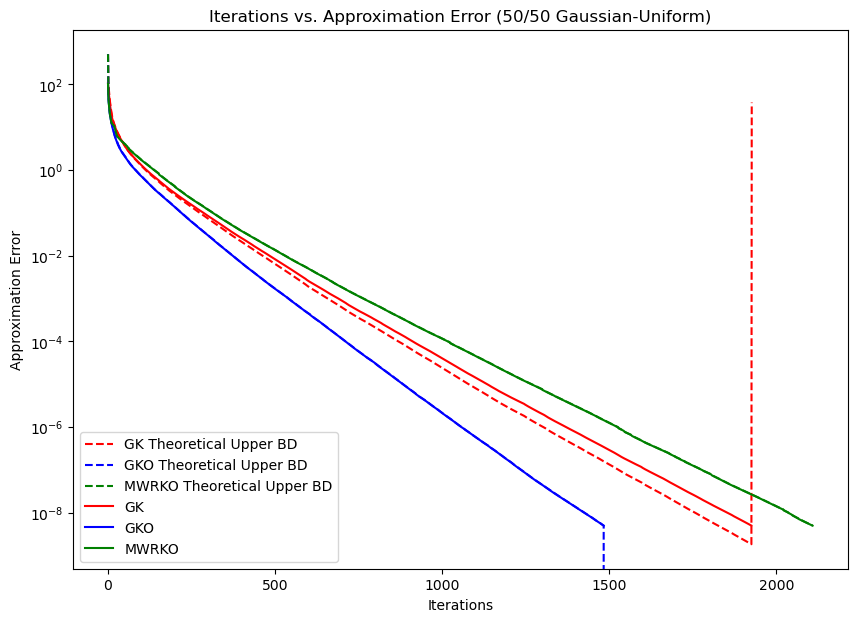

In [24]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu1[2])), gk_gu1[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu1[2])), gko_gu1[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu1[2])), mwrko_gu1[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu1[0] - 1), gk_gu1[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu1[0] - 1), gko_gu1[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu1[0] - 1), mwrko_gu1[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gaussian-Uniform)')
plt.legend()

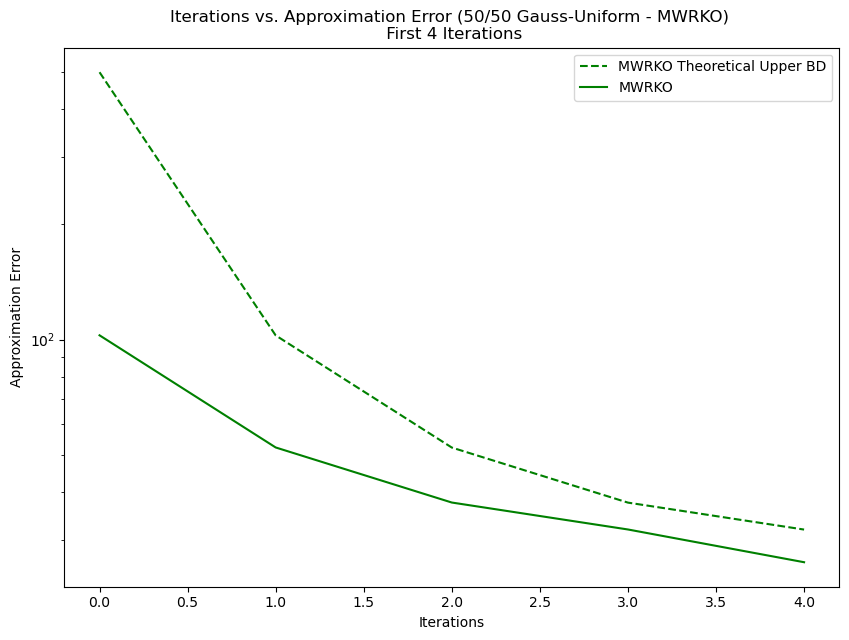

In [25]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gu1[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gu1[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (50/50 Gauss-Uniform - MWRKO) \n First 4 Iterations')
plt.legend()

In [26]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu1[0]-9), mwrko_gu1[0]+1)))
# empirical result data
e_result = list(mwrko_gu1[1][0:10])
e_result.extend(list(mwrko_gu1[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu1[2][0:10])
t_result.extend(list(mwrko_gu1[2][-11:-1]))
# create and print df
mwrko_gu1_df = pd.DataFrame()
mwrko_gu1_df['k'] = k
mwrko_gu1_df['Theoretical BD'] = t_result
mwrko_gu1_df['Empirical Results'] = e_result
mwrko_gu1_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,2.101000e+03,2.102000e+03,2.103000e+03,2.104000e+03,2.105000e+03,2.106000e+03,2.107000e+03,2.108000e+03,2.109000e+03,2.110000e+03
Theoretical BD,499.737622,102.523775,52.200318,37.473739,31.863536,26.164229,21.465203,19.504042,17.416585,15.368318,5.451699e-09,5.406610e-09,5.361890e-09,5.314791e-09,5.271069e-09,5.225802e-09,5.177748e-09,5.131028e-09,5.087705e-09,5.040915e-09
Empirical Results,102.577614,52.227736,37.493421,31.880272,26.177971,21.476478,19.514286,17.425733,15.376390,14.212646,5.409450e-09,5.364707e-09,5.317582e-09,5.273838e-09,5.228547e-09,5.180468e-09,5.133723e-09,5.090377e-09,5.043563e-09,5.002741e-09


## 75/25 Gauss-Uniform System

In [27]:
# setting up data
A1 = np.random.rand(1250,500)
A2 = np.random.randn(3750,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [28]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [29]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [30]:
# Run algorithms
gk_gu2 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu2 = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu2 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

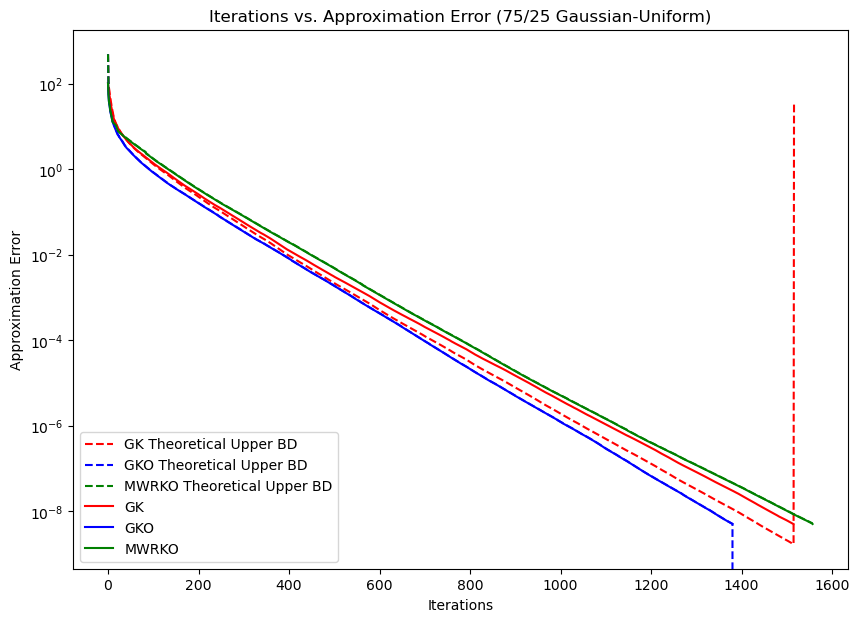

In [31]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu2[2])), gk_gu2[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu2[2])), gko_gu2[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu2[2])), mwrko_gu2[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu2[0] - 1), gk_gu2[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu2[0] - 1), gko_gu2[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu2[0] - 1), mwrko_gu2[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gaussian-Uniform)')
plt.legend()

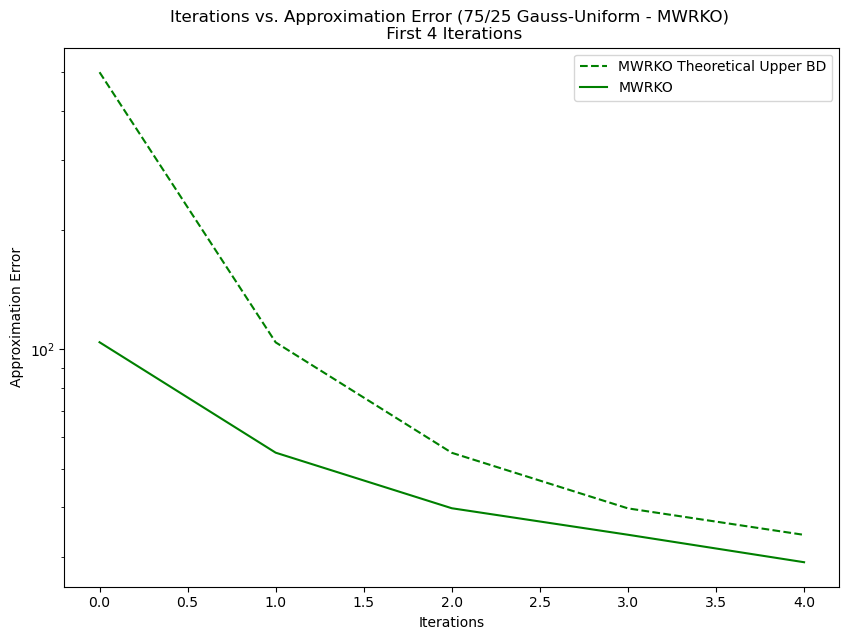

In [32]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gu2[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gu2[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (75/25 Gauss-Uniform - MWRKO) \n First 4 Iterations')
plt.legend()

In [33]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu2[0]-9), mwrko_gu2[0]+1)))
# empirical result data
e_result = list(mwrko_gu2[1][0:10])
e_result.extend(list(mwrko_gu2[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu2[2][0:10])
t_result.extend(list(mwrko_gu2[2][-11:-1]))
# create and print df
mwrko_gu2_df = pd.DataFrame()
mwrko_gu2_df['k'] = k
mwrko_gu2_df['Theoretical BD'] = t_result
mwrko_gu2_df['Empirical Results'] = e_result
mwrko_gu2_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,1.550000e+03,1.551000e+03,1.552000e+03,1.553000e+03,1.554000e+03,1.555000e+03,1.556000e+03,1.557000e+03,1.558000e+03,1.559000e+03
Theoretical BD,499.638561,104.200359,54.898999,39.767402,34.099935,29.074983,23.859987,21.777033,19.177996,17.108378,5.812674e-09,5.745226e-09,5.667724e-09,5.599411e-09,5.531894e-09,5.463382e-09,5.397312e-09,5.329001e-09,5.266047e-09,5.203383e-09
Empirical Results,104.275753,54.938729,39.796181,34.124613,29.096024,23.877254,21.792793,19.191875,17.120760,15.022522,5.749384e-09,5.671826e-09,5.603463e-09,5.535897e-09,5.467336e-09,5.401218e-09,5.332858e-09,5.269858e-09,5.207148e-09,5.146477e-09


## 25/75 Gauss-Uniform System

In [34]:
# setting up data
A1 = np.random.rand(3750,500)
A2 = np.random.randn(1250,500)
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [35]:
# Find the minimum singular value
U,S,V = np.linalg.svd(A)
S2_min = min(S**2)
# Find the max angle
angles_g = compute_sin2(A)
max_angle_g = max(angles_g)
# Find the row norm
row_norm_g = np.sum(np.abs(A)**2,axis=-1)
max_row_norm_g = max(row_norm_g)

In [36]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [37]:
# Run algorithms
gk_gu3 = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_gu3 = method2(A,x,y,'GKO', LHk_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_gu3 = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

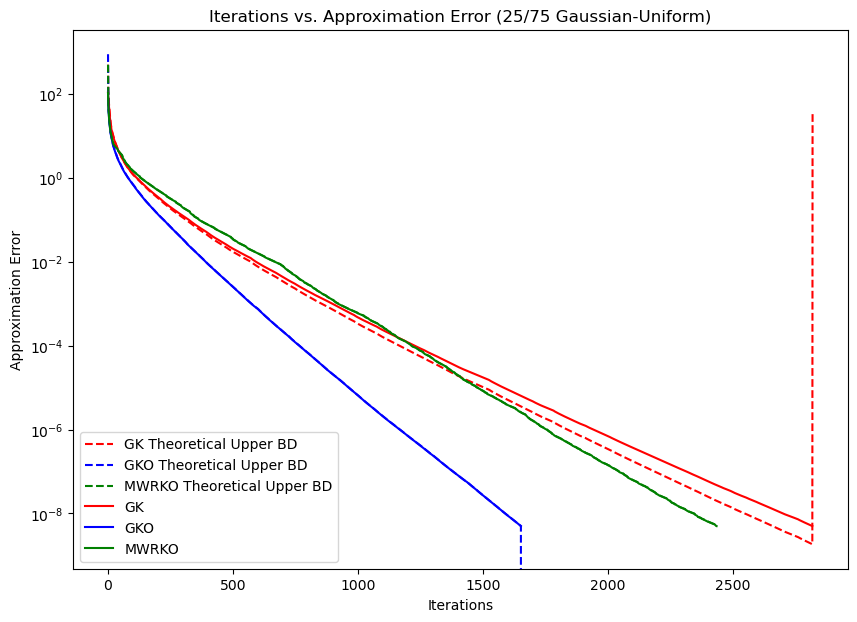

In [38]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_gu3[2])), gk_gu3[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_gu3[2])), gko_gu3[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_gu3[2])), mwrko_gu3[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_gu3[0] - 1), gk_gu3[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_gu3[0] - 1), gko_gu3[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_gu3[0] - 1), mwrko_gu3[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gaussian-Uniform)')
plt.legend()

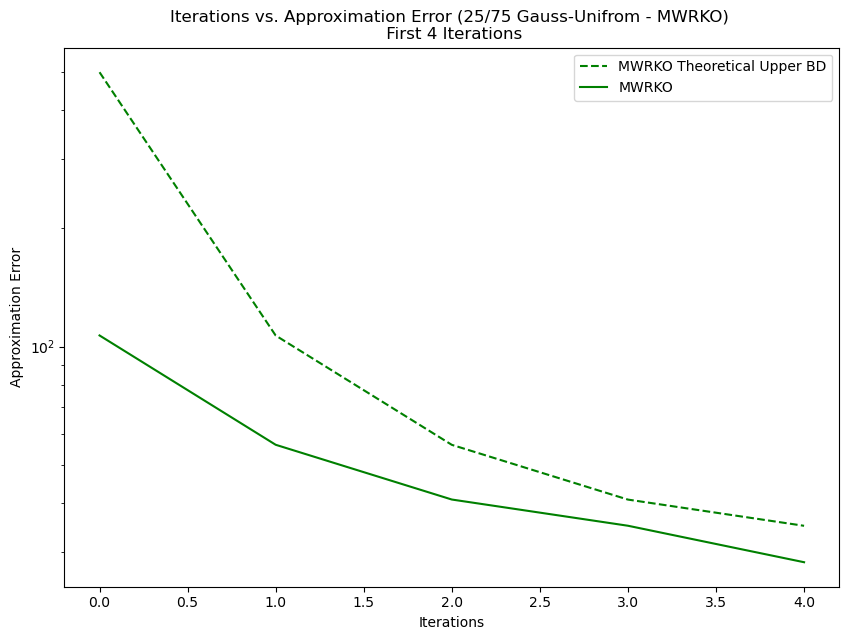

In [39]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_gu3[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_gu3[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (25/75 Gauss-Unifrom - MWRKO) \n First 4 Iterations')
plt.legend()

In [40]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_gu3[0]-9), mwrko_gu3[0]+1)))
# empirical result data
e_result = list(mwrko_gu3[1][0:10])
e_result.extend(list(mwrko_gu3[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_gu3[2][0:10])
t_result.extend(list(mwrko_gu3[2][-11:-1]))
# create and print df
mwrko_gu3_df = pd.DataFrame()
mwrko_gu3_df['k'] = k
mwrko_gu3_df['Theoretical BD'] = t_result
mwrko_gu3_df['Empirical Results'] = e_result
mwrko_gu3_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,2.428000e+03,2.429000e+03,2.430000e+03,2.431000e+03,2.432000e+03,2.433000e+03,2.434000e+03,2.435000e+03,2.436000e+03,2.437000e+03
Theoretical BD,499.822085,106.713329,56.205895,40.767890,34.958628,28.225248,22.633618,20.526865,17.852517,15.724624,5.597809e-09,5.568006e-09,5.538494e-09,5.508415e-09,5.439783e-09,5.345042e-09,5.260810e-09,5.180393e-09,5.110248e-09,5.034739e-09
Empirical Results,106.751322,56.225910,40.782408,34.971077,28.235299,22.641678,20.534174,17.858874,15.730224,14.113255,5.569988e-09,5.540467e-09,5.510377e-09,5.441720e-09,5.346946e-09,5.262683e-09,5.182238e-09,5.112068e-09,5.036532e-09,5.008735e-09


## Two Highly Correlated Systems

In [41]:
# setting up data
# Step 1: generate two gaussian linear system
A = np.random.randn(2,500)
A1 = np.reshape(A[0,:], (1, 500))
A2 = np.reshape(A[1,:], (1, 500))
# Step 2: generate correalted systems
U = np.random.uniform(low = 0, high = 1, size  = (2500,500))
A1 =  np.tile(A1, (2500, 1)) +  U
A2 =  np.tile(A2, (2500, 1)) +  U
# Step 3: Combine two correlated systems
A = np.concatenate((A1, A2))
A = normalize(A, axis=1, norm='l2')
x = np.ones(500)
y = A @ x
TOL = 10**-4

In [42]:
# Compute LH of convergence rate
# gk (LH1 = LH2 = 0)
LHk_gk = 1- ( S2_min / m )
# gko
LH1_gko = 1 - ( S2_min / m )
#LH2_gko = S2_min / (max_angle_g * (m-1)) )
LHk_gko = S2_min / max_angle_g 
# mwrko
LH1_mwrko = 1 - ( S2_min / m )
LH2_mwrko = 1- ( S2_min / (max_angle_g * (m-1)) )
LHk_mwrko =  1- ( S2_min / (max_angle_g * (m-2)) )

In [43]:
# Run algorithms
gk_corr = method2(A,x,y,'GK', 0, 0, LHk_gk, 0.5*10**-8)
gko_corr = method2(A,x,y,'GKO', LH1_gko, LHk_gko, LHk_gko, 0.5*10**-8)
mwrko_corr = method2(A,x,y,'MWRKO', LH1_mwrko, LH2_mwrko, LHk_mwrko,0.5*10**-8)

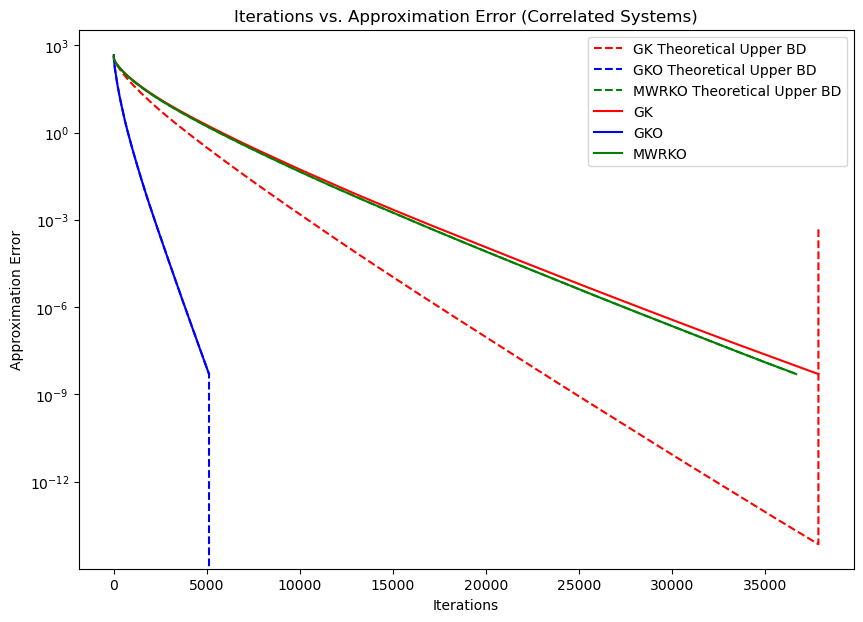

In [44]:
# plot the results with the theoretical upper bound
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(len(gk_corr[2])), gk_corr[2], linestyle = 'dashed',
             color = "red", label = 'GK Theoretical Upper BD')
plt.semilogy(np.arange(len(gko_corr[2])), gko_corr[2], linestyle = 'dashed', 
             color = "blue", label = 'GKO Theoretical Upper BD')
plt.semilogy(np.arange(len(mwrko_corr[2])), mwrko_corr[2], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(gk_corr[0] - 1), gk_corr[1], 
             color = "red", linestyle = 'solid', label = 'GK')
plt.semilogy(np.arange(gko_corr[0] - 1), gko_corr[1], linestyle = 'solid', 
             color = "blue", label = 'GKO')
plt.semilogy(np.arange(mwrko_corr[0] - 1), mwrko_corr[1], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems)')
plt.legend()

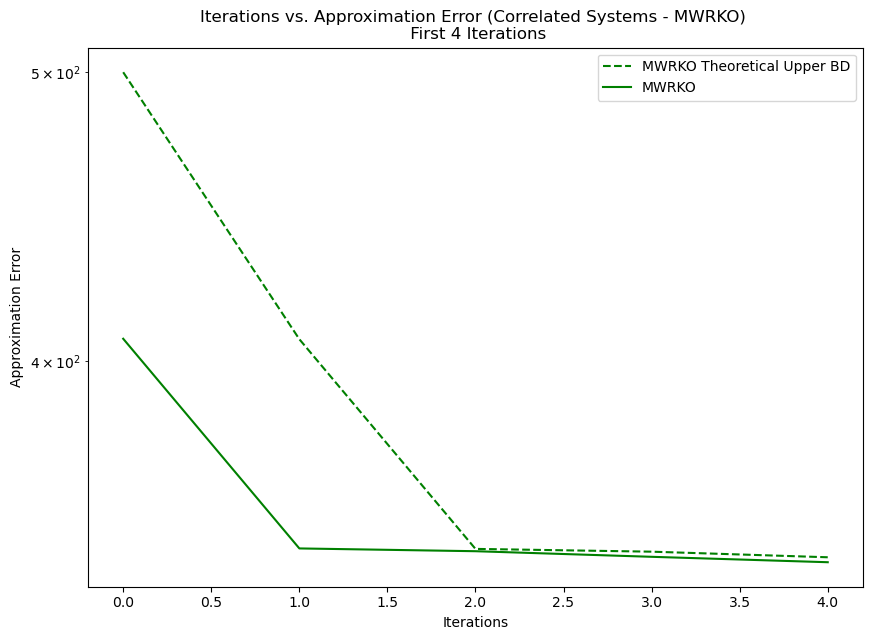

In [45]:
# Show MWRKO empirical and theoretical results
plt.figure(figsize=(10,7))
# plot theoretical bound
plt.semilogy(np.arange(5), mwrko_corr[2][0:5], linestyle = 'dashed', 
             color = "green", label = 'MWRKO Theoretical Upper BD')
# plot empirical results
plt.semilogy(np.arange(5), mwrko_corr[1][0:5], linestyle = 'solid', 
             color = "green", label = 'MWRKO')
# labels
plt.xlabel('Iterations')
plt.ylabel('Approximation Error')
plt.title('Iterations vs. Approximation Error (Correlated Systems - MWRKO) \n First 4 Iterations')
plt.legend()

In [46]:
# table
k = list(range(1,11))
k.extend(list(range((mwrko_corr[0]-9), mwrko_corr[0]+1)))
# empirical result data
e_result = list(mwrko_corr[1][0:10])
e_result.extend(list(mwrko_corr[1][-11:-1]))
# theoretical result data
t_result = list(mwrko_corr[2][0:10])
t_result.extend(list(mwrko_corr[2][-11:-1]))
# create and print df
mwrko_corr_df = pd.DataFrame()
mwrko_corr_df['k'] = k
mwrko_corr_df['Theoretical BD'] = t_result
mwrko_corr_df['Empirical Results'] = e_result
mwrko_corr_df.T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
k,1.000000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,3.666800e+04,3.666900e+04,3.667000e+04,3.667100e+04,3.667200e+04,3.667300e+04,3.667400e+04,3.667500e+04,3.667600e+04,3.667700e+04
Theoretical BD,499.822085,406.754308,345.978672,345.237490,343.749907,342.316089,340.899651,339.525221,338.178982,336.832651,5.026297e-09,5.023482e-09,5.020697e-09,5.017901e-09,5.015124e-09,5.012324e-09,5.009515e-09,5.006695e-09,5.003880e-09,5.001093e-09
Empirical Results,406.899124,346.101875,345.360429,343.872317,342.437988,341.021045,339.646126,338.299407,336.952597,335.609599,5.025271e-09,5.022485e-09,5.019688e-09,5.016909e-09,5.014108e-09,5.011299e-09,5.008478e-09,5.005662e-09,5.002874e-09,5.000079e-09
